In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cygnus_lib as cy
import mylib as my
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
%matplotlib inline
x_resolution = y_resolution = 2048
import os
import requests


# Load file and show plots

In [76]:
VarNames=["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"]
C_file = './data/dbscan_run2273_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_101.txt'
C_file = './data/dbscan_run2277_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_948.txt'
#C_file = './data/dbscan_run2320_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_1003.txt'
#C_file = './data/dbscan_run2318_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_1001.txt'
C_file = './data/dbscan_run2163_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_869_ped_2151.txt'
C_file = './data/dbscan_run2164_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_1000_ped_2151.txt'
#################
C_file = './data/dbscan_run2353_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_1250_ped_2356.txt'
C_file = './data/dbscan_run2354_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_744_ped_2356.txt'
C_file = './data/dbscan_run2357_cmin_0_cmax_300_rescale_576_nsigma_1.5_ev_1000_ped_2358.txt'
C_file = './data/dbscan_run2359_cmin_0_cmax_300_rescale_576_nsigma_1.5_ev_1000_ped_2358.txt'
############### MANGO
#C_file = './data/dbscan_run2322_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_100_ped_2340.txt'
#C_file = './data/dbscan_run2346_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_301_ped_2340.txt'
C_file = './data/dbscan_run2338_cmin_0_cmax_300_rescale_256_nsigma_1.5_ev_203_ped_2340.txt'
C_file = './data/dbscan_run2338_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_203_ped_2340.txt'

df = pd.read_csv(C_file, sep=" ", dtype='float64', names=VarNames)

# range
# charge distribution
# charge asimettriy
df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.

In [84]:
var = C_file.split('.')[1:2][0].split('_')
for i in range(0, len(var)-1, 2):
    var_name = var[i:i+1]
    var_val = var [i+1:i+2]
    print (var_name, var_val)
from platform import python_version
python_version().split('.')[0]

['/data/dbscan'] ['run2338']
['cmin'] ['0']
['cmax'] ['300']
['rescale'] ['512']
['nsigma'] ['1']


'3'

# LEMON Parameters

In [78]:
LEMON = False

if LEMON:
    # LEMON
    phKev       = 1730/5.9
    pixelscale  = 0.125 
    rescale = 512
else:
    phKev       = 10000/5.9
    pixelscale  = 0.55 
    rescale = 512


xyscale = x_resolution/rescale
rescale_pixelscale = xyscale*pixelscale
print("Scale: %d Pixel/Mpixel, %.2f [mm/Mpixel]" % (xyscale, rescale_pixelscale))


Scale: 4 Pixel/Mpixel, 2.20 [mm/Mpixel]


In [79]:
df.head()#[df['cluster_lable']==2]
#df.iloc[:,1:4].head()

,iTr,cluster_lable,pixels,photons,ph_pixels,x0start,y0start,x0end,y0end,width,height,pearson,length,x0c,y0c
0,0.0,-1.0,483.0,1940.130614,4.016834,0.0,48.0,511.0,120.0,1.972703,2.026929,-0.027111,516.047478,255.5,84.0
1,0.0,0.0,6.0,27.067428,4.511238,0.0,379.0,13.0,386.0,2.759864,0.618991,0.904212,14.764823,6.5,382.5
2,0.0,1.0,2.0,10.182198,5.091099,1.0,30.0,6.0,33.0,2.828427,0.000000,1.000000,5.830952,3.5,31.5
3,0.0,2.0,4.0,18.141529,4.535382,3.0,173.0,8.0,176.0,1.956122,2.042935,-0.043396,5.830952,5.5,174.5
4,0.0,3.0,10.0,45.138598,4.513860,3.0,414.0,22.0,410.0,1.641949,2.303043,-0.326001,19.416488,12.5,412.0


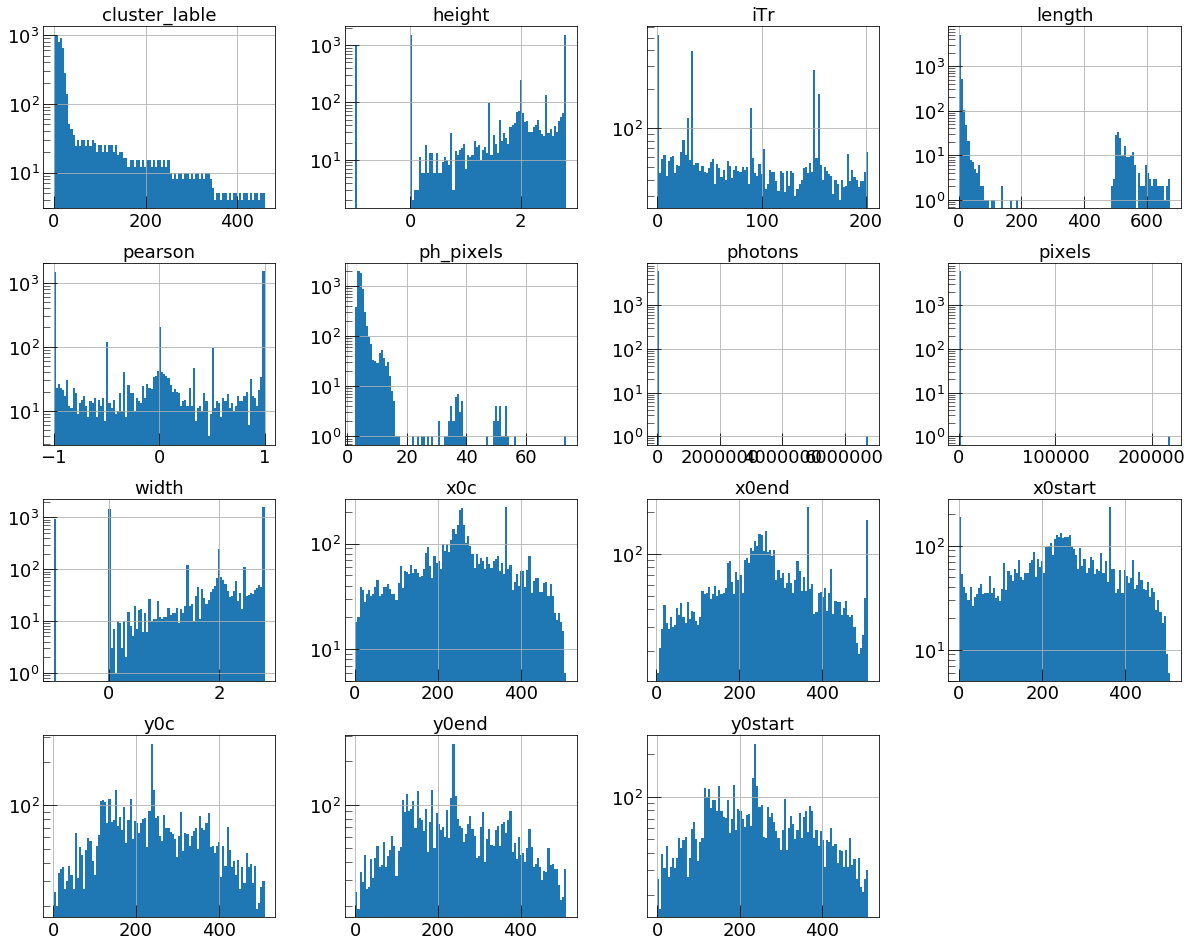

In [80]:
df.hist(bins=100, figsize=(20,15), log=True)
plt.show()

# Custs & Normalizzation

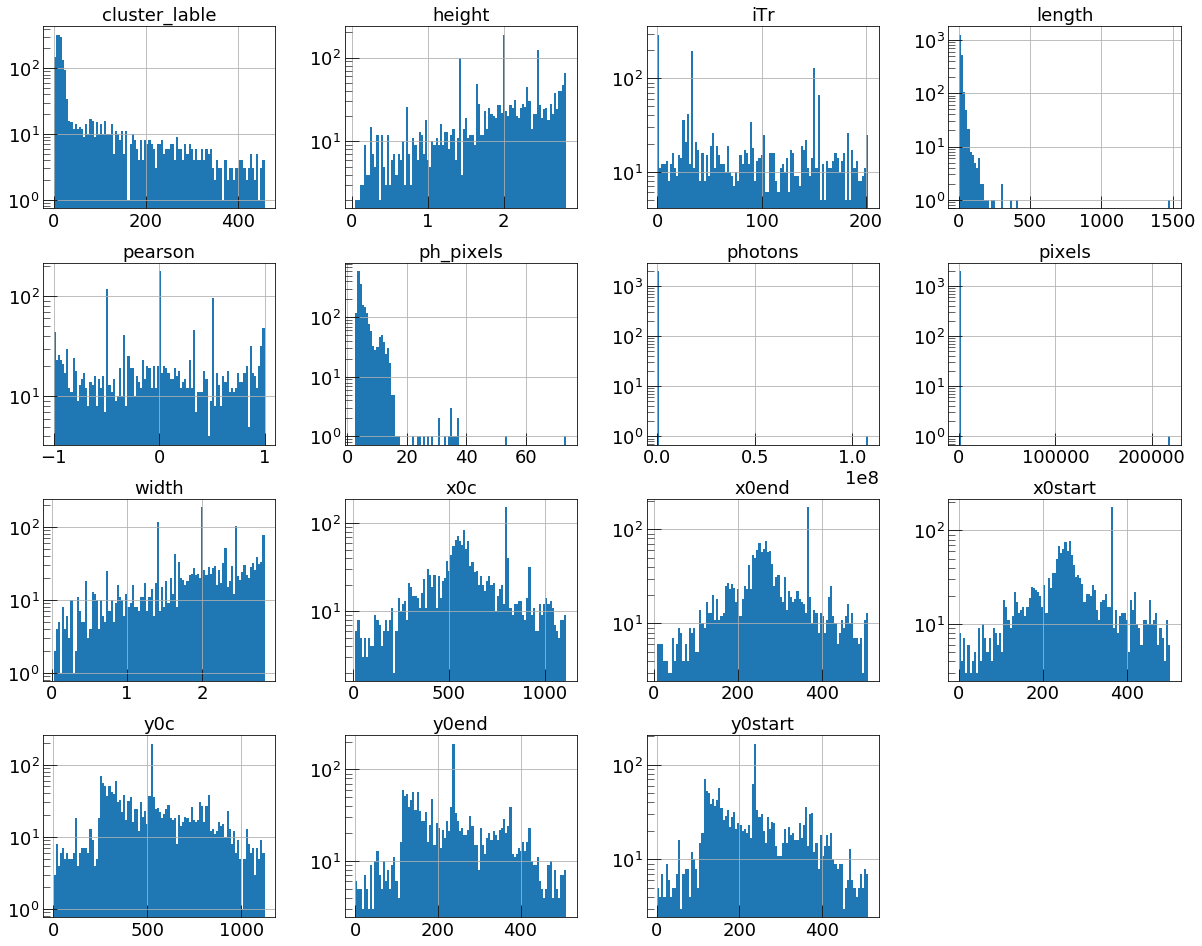

In [81]:


dfc = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]

# Normalization
dfc.loc[:,'photons']  =dfc['photons']*xyscale*xyscale
dfc.loc[:,'length']   =dfc['length']*rescale_pixelscale
dfc.loc[:,'x0c']      =dfc['x0c']*rescale_pixelscale
dfc.loc[:,'y0c']      =dfc['y0c']*rescale_pixelscale

# fiducializzation

if LEMON:
    DX = 0 
    DY = 0
    a = 100. # mm
    b = 120. # mm

    a0 = a*0.5
    b0 = b*0.5
    print ("Fidical Ellips: %.2f, %.2f [mm]" % (a,b))

    d0 = x_resolution*pixelscale/2

    fig, ax = plt.subplots(1,3, figsize=(20, 6))

    y = dfc['y0c']
    x = dfc['x0c']
    x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
    y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
    ax[0].plot(y, x, 'r.', markersize=3)
    ax[0].plot(y1, x1, 'b.', markersize=3)

    ax[1].hist(x, color='r')
    ax[1].hist(x1, color='b')
    ax[2].hist(y, color='r')
    ax[2].hist(y1, color='b')
    plt.show()

    dfc = dfc[((dfc['x0c']-d0)**2/a0**2 + (dfc['y0c']-d0)**2/b0**2 )< 1]

dfc.hist(bins=100, figsize=(20,15), log=True)
plt.show()

43 100 0.430001733022525 14085.56586832 132.1337325344


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


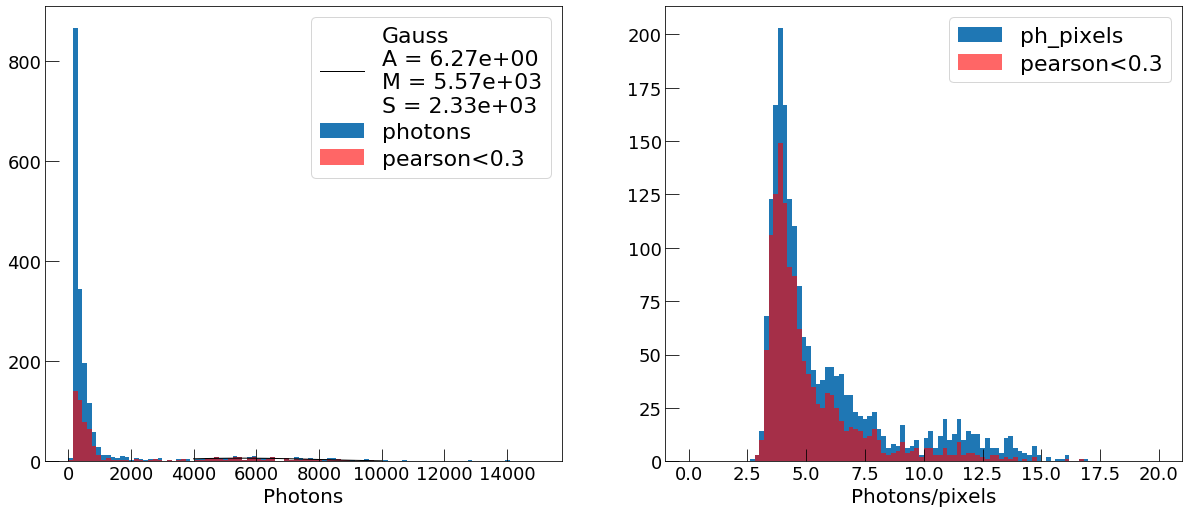

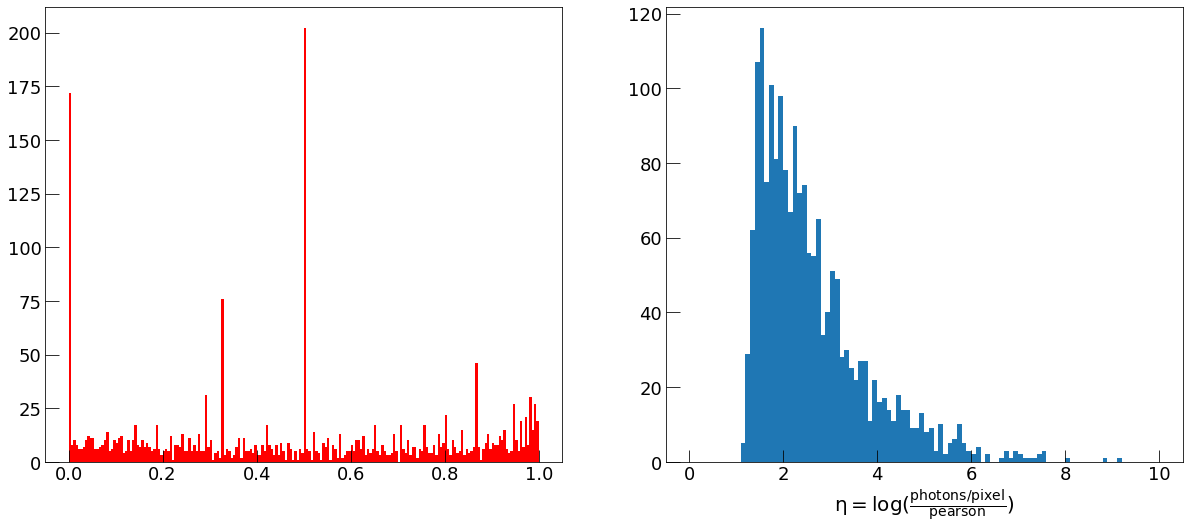

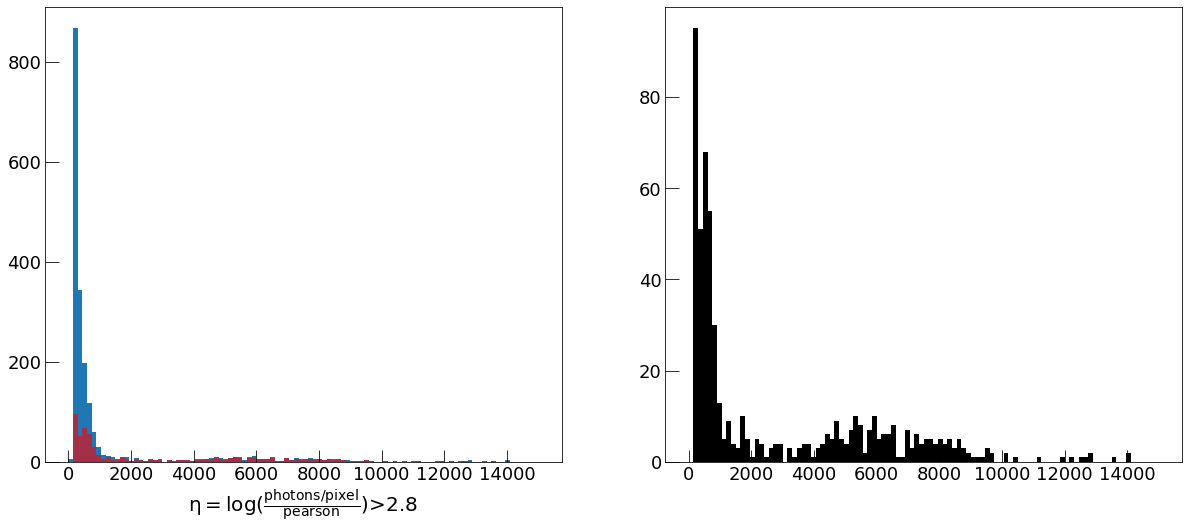

In [82]:
# File Type:
Fe = True
cy.set_atlas_style('square')
from scipy.optimize import curve_fit
if Fe:
    gauss = True
    pearson_cut = 0.3
else:
    gauss = False
    pearson_cut = 0.7
max_range = 15000
max_pearson = 20
fig, ax = plt.subplots(1,2, figsize=(20, 8))
bins=100
ax[0].hist(dfc['photons'], bins=bins, range=(0,max_range))
ax[0].hist(dfc['photons'][abs(dfc['pearson'])<pearson_cut], bins=bins, range=(0,max_range), color='red', 
           alpha=0.6, label = ('pearson<%.1f'%pearson_cut))

ax[0].set_xlabel("Photons")
if gauss:
    cmin    = 4000
    cmax    = 10000
    y = dfc['photons'][abs(dfc['pearson'])<pearson_cut]
    y = y[y<max_range]
    binsf = int(bins*((cmax-cmin)/(y.max()-y.min())))
    print (binsf, bins, (cmax-cmin)/(y.max()-y.min()), y.max(), y.min())
    yh, bins_edge = np.histogram(y, bins=binsf, range=(cmin,cmax))
    sum_yh   = float(sum(yh))
    x       = np.linspace(cmin, cmax, binsf)
    ye      = 1/np.sqrt(yh)
    #ax[0].errorbar(x, yh, ye, fmt="k.")
    A, M, S = yh.max(), y.mean(), y.std()

    popt, pcov = curve_fit(my.Gauss3, x, yh, 
                            sigma=ye,
                            absolute_sigma=True,
                            p0=(A, M, S))
    xf = np.linspace(cmin, cmax, 100)
    ax[0].plot(xf, my.Gauss3(xf, *popt), 'k-', label='Gauss\nA = %.2e\nM = %.2e\nS = %.2e' % 
                          (popt[0], popt[1], popt[2]))
    ph_f = popt[1]
    ax[0].legend()
    
bins=100
ax[0].legend()
ax[1].hist(dfc['ph_pixels'], bins=bins, range=(0,max_pearson))
ax[1].hist(dfc['ph_pixels'][abs(dfc['pearson'])>pearson_cut], bins=bins, color='red', range=(0,max_pearson),
           alpha=0.6, label = ('pearson<%.1f'%pearson_cut))

ax[1].set_xlabel("Photons/pixels")
ax[1].legend()
plt.show()


eta = np.log(dfc['ph_pixels']/abs(dfc['pearson'])[abs(dfc['pearson'])>0])
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].hist(abs(dfc['pearson']), bins=200, 
           color='r')
ax[1].hist(eta, bins=100, range=(0,10))
ax[1].set_xlabel(r"$\eta = log (\frac {photons/pixel} {pearson})$")
plt.show()

eta_cut = 2.8
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].hist(dfc['photons'], bins=bins, range=(0,max_range))

ax[0].hist(dfc['photons'][eta>eta_cut], bins=bins, range=(0,max_range), color='red', 
           alpha=0.6)
ax[0].set_xlabel(r"$\eta = log (\frac {photons/pixel} {pearson})$>%.1f" % eta_cut)
ax[1].hist(dfc['photons'][eta>eta_cut], bins=bins, range=(0,max_range), color='black')
plt.show()

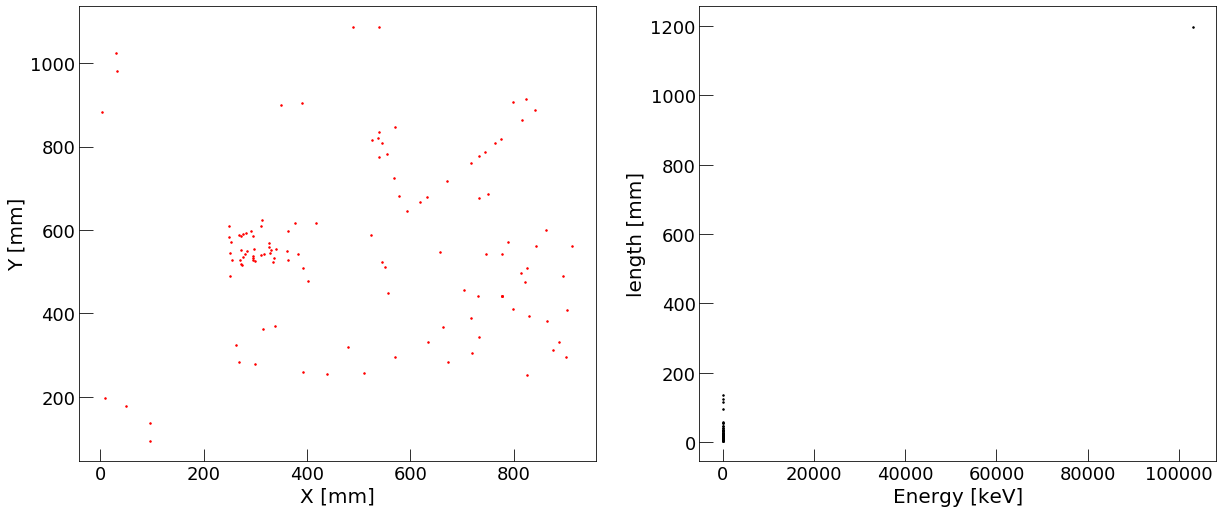

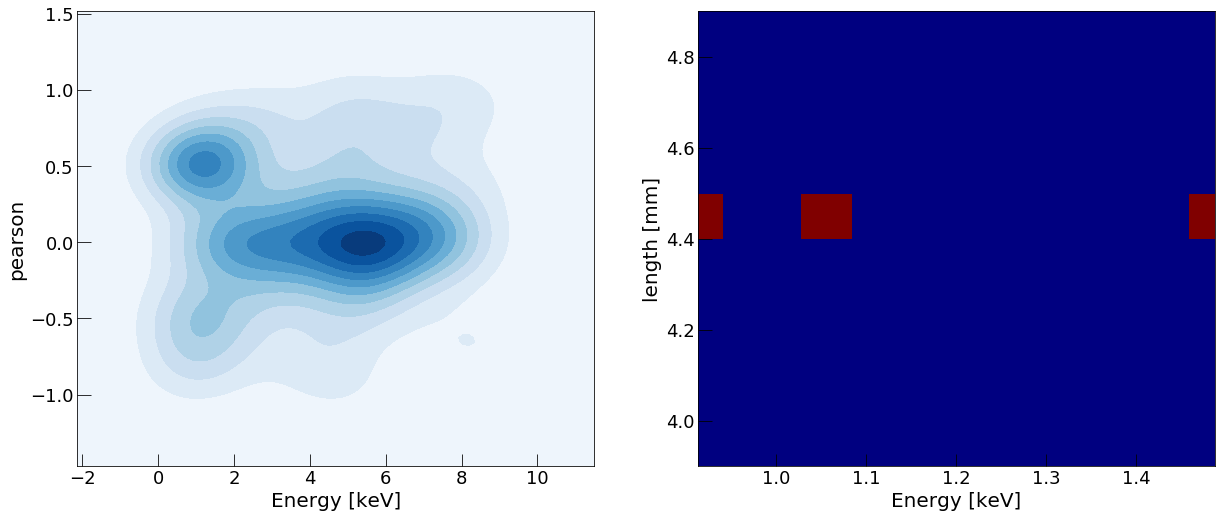

In [72]:
#plt.plot(df['y0start'], df['x0start'], 'k.', markersize=1)
import seaborn as sns
######################
### se lo vuoi dal prcedente fit
if Fe:
    phKev = ph_f/5.9
#####################
y = dfc['y0c']
x = dfc['x0c']
l = dfc['length']
e = dfc['photons']/phKev
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(y, x, 'r.', markersize=3)
ax[0].set_xlabel("X [mm]")
ax[0].set_ylabel("Y [mm]")
ax[1].plot(e, l, 'k.', markersize=3)
ax[1].set_xlabel("Energy [keV]")
ax[1].set_ylabel("length [mm]")
plt.show()
fig, ax = plt.subplots(1,2, figsize=(20, 8))
#ax[0].scatter(df['width'],df['height'],df['pixels']/10 )
#ax[0].set_xlabel("width")
#ax[0].set_ylabel("height")
#ax[0].hist2d(e[(e<10)], dfc['pearson'][(e<10)], bins=(10,10), cmap=plt.cm.jet)
sns.kdeplot(e[(e<10)], dfc['pearson'][(e<10)], ax=ax[0], cmap="Blues", shade=True, shade_lowest=True, )
ax[0].set_xlabel("Energy [keV]")
#ax[1].plot(e[e<20], l[e<20], 'k.', markersize=5)
ax[1].hist2d(e[(e<10) & (l<5)], l[(e<10) & (l<5)], bins=(20,10), cmap=plt.cm.jet)
ax[1].set_xlabel("Energy [keV]")
ax[1].set_ylabel("length [mm]")
plt.show()

# Analsi comparata

In [ ]:
VarNames=["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"]
#######################
#C_file = './data/dbscan_run1514_cmin_95_cmax_300_rescale_256_rebin_th_image_116_ev_100.txt' # AmBe 450
#C_file = './data/dbscan_run1514_cmin_95_cmax_300_rescale_256_rebin_th_image_117_ev_100.txt' # AmBe 450
#C_file = './data/dbscan_run1514_cmin_95_cmax_300_rescale_256_rebin_th_image_120_ev_100.txt' # AmBe 450
#C_file = './data/dbscan_run494_cmin_95_cmax_300_rescale_256_rebin_th_image_105_ev_100.txt' # AmBe ORANGE 440
C_file = './data/dbscan_run494_cmin_0_cmax_300_rescale_256_rebin_th_image_5_ev_100.txt' # AmBe ORANGE 440
C_file = './data/dbscan_run740_cmin_0_cmax_300_rescale_512_rebin_th_image_5_ev_100.txt' # AmBe LEMON 450
ambe = pd.read_csv(C_file, sep=" ", dtype='float64', names=VarNames).replace([np.inf, -np.inf], 5)
########################
#C_file = './data/dbscan_run725_cmin_95_cmax_300_rescale_256_rebin_th_image_101_ev_100.txt' # Co60 LEMON 450
C_file = './data/dbscan_run722_cmin_0_cmax_300_rescale_256_rebin_th_image_2_ev_100.txt' # Co60 ORANGE 440
C_file = './data/dbscan_run725_cmin_0_cmax_300_rescale_512_rebin_th_image_6_ev_100.txt' # Co60 LEMON 450
co60 = pd.read_csv(C_file, sep=" ", dtype='float64', names=VarNames)
ambe['length'] = np.sqrt((ambe['x0end'] - ambe['x0start'])**2 + (ambe['y0end'] - ambe['y0start'])**2)
ambe['x0c'] = (ambe['x0end'] + ambe['x0start'])/2.
ambe['y0c'] = (ambe['y0end'] + ambe['y0start'])/2.

co60['length'] = np.sqrt((co60['x0end'] - co60['x0start'])**2 + (co60['y0end'] - co60['y0start'])**2)
co60['x0c'] = (co60['x0end'] + co60['x0start'])/2.
co60['y0c'] = (co60['y0end'] + co60['y0start'])/2.

ambe.loc[:,'photons']  = ambe['photons']*xyscale*xyscale
ambe.loc[:,'length']   = ambe['length']*rescale_pixelscale
ambe.loc[:,'x0c']      = ambe['x0c']*rescale_pixelscale
ambe.loc[:,'y0c']      = ambe['y0c']*rescale_pixelscale
co60.loc[:,'photons']  = co60['photons']*xyscale*xyscale
co60.loc[:,'length']   = co60['length']*rescale_pixelscale
co60.loc[:,'x0c']      = co60['x0c']*rescale_pixelscale
co60.loc[:,'y0c']      = co60['y0c']*rescale_pixelscale

ambe['energy']         = ambe['photons']/phKev
co60['energy']         = co60['photons']/phKev

ambe = ambe[(ambe['cluster_lable'] > -1) & (ambe['width'] > 0) & (ambe['height'] > 0) & (ambe['ph_pixels'] < 30)]
co60 = co60[(co60['cluster_lable'] > -1) & (co60['width'] > 0) & (co60['height'] > 0) & (co60['ph_pixels'] < 30)]

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(ambe['energy'], ambe['length'], 'b.', markersize=3, label='AmBe')
ax[0].plot(co60['energy'], co60['length'], 'r.', markersize=3, alpha=0.8, label='Co60')
ax[1].plot(ambe['energy'], ambe['length'], 'b.', markersize=3, label='AmBe')
ax[1].plot(co60['energy'], co60['length'], 'r.', markersize=3, alpha=0.8, label='Co60')

#plt.plot(cosmic['photons']/phKev, cosmic['length']*rescale_pixelscale, 'g.', markersize=2, alpha=0.4)

ax[0].set_xlabel("Energy [keV]")
ax[0].set_ylabel("length [mm]")
ax[1].set_xlabel("Energy [keV]")
ax[1].set_ylabel("length [mm]")

ax[1].set_xlim(0,30)
ax[1].set_ylim(0,10)
ax[0].legend()
ax[1].legend()


plt.show()

p_cor = 0.7

fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(ambe['energy'][abs(ambe['pearson'])>p_cor], ambe['length'][abs(ambe['pearson'])>p_cor], 
           'b.', markersize=3, label=('AmBe pearson > %.2f' % p_cor))
ax[0].plot(co60['energy'][abs(co60['pearson'])>p_cor], co60['length'][abs(co60['pearson'])>p_cor], 
           'r.', markersize=3, alpha=0.8, label=('Co60 pearson > %.2f' % p_cor))
ax[1].plot(ambe['energy'][abs(ambe['pearson'])>p_cor], ambe['length'][abs(ambe['pearson'])>p_cor], 
           'b.', markersize=3, label=('AmBe pearson > %.2f' % p_cor))
ax[1].plot(co60['energy'][abs(co60['pearson'])>p_cor], co60['length'][abs(co60['pearson'])>p_cor], 
           'r.', markersize=3, alpha=0.8, label=('Co60 pearson > %.2f' % p_cor))


ax[0].set_xlabel("Energy [keV]")
ax[0].set_ylabel("length [mm]")
ax[1].set_xlabel("Energy [keV]")
ax[1].set_ylabel("length [mm]")

ax[1].set_xlim(0,30)
ax[1].set_ylim(0,10)
ax[0].legend()
ax[1].legend()


plt.show()

fig, ax = plt.subplots(1,2, figsize=(20, 8))

#ax[0].hist(ambe['length']*rescale_pixelscale, bins=100, color='b')
#ax[0].hist(co60['length']*rescale_pixelscale, bins=100, color='r', alpha=0.6)
ax[0].hist(np.log(ambe['ph_pixels']/(ambe['length'][ambe['length']>0])), bins=50,
           color='b', label='AmBe')
ax[0].hist(np.log(co60['ph_pixels']/(co60['length'][co60['length']>0])), bins=50, 
           color='r', alpha=0.6, label='Co60')

ax[0].set_xlabel(r"$\chi = log (\frac {photons/pixels} {length})$")




eta_ambe = np.log((ambe['ph_pixels']*abs(ambe['pearson']))[abs(ambe['pearson'])>p_cor])
eta_co60 = np.log((co60['ph_pixels']*abs(co60['pearson']))[abs(co60['pearson'])>p_cor])

ax[1].hist(eta_ambe, label=('AmBe pearson > %.2f' % p_cor), bins=50, color='b')
ax[1].hist(eta_co60,label=('Co60 pearson > %.2f' % p_cor), bins=50, color='r', alpha=0.6)

ax[1].set_xlabel(r"$\eta = log (\frac {photons} {pixels} \times {pearson})$")

ax[0].legend()
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(abs(ambe['pearson'][abs(ambe['pearson'])>p_cor]), 
           eta_ambe, 
           'b.', markersize=3, label=('AmBe pearson > %.2f' % p_cor))
ax[0].plot(abs(co60['pearson'][abs(co60['pearson'])>p_cor]), 
           eta_co60,
           'r.', markersize=3, alpha=0.8, label=('Co60 pearson > %.2f' % p_cor))


ambe_h, ambe_bins = np.histogram(eta_ambe, 
                            bins=40, range=(-4,5))
co60_h, co60_bins = np.histogram(eta_co60, 
                            bins=40, range=(-4,5))

ene_h, ene_bins = np.histogram((ambe['energy'][abs(ambe['pearson'])>p_cor]), 
                            bins=40, range=(-4,5))

ax[0].set_xlabel("pearson")
ax[0].set_ylabel(r"$\eta$")
#ax[1].bar(ambe_bins[:-1], ambe_h, width=0.3, color='b')
#ax[1].bar(co60_bins[:-1], co60_h, width=0.3, color='r', alpha=0.8)
detec_eff = (ambe_h[ambe_h>0]-co60_h[ambe_h>0])/ambe_h[ambe_h>0]

detec_bins = ambe_bins[:-1][ambe_h>0]
ax[1].plot(detec_bins, detec_eff,'k-', label=('pearson > %.2f' % p_cor))
#ax[0].set_ylim(0,100)

#ax[1].set_xlabel("Energy [keV]")
#ax[1].set_ylabel(r"$\eta$")

#ax[1].set_xlim(0,30)
ax[1].set_ylim(0,1.1)
ax[0].legend()
ax[1].legend()

plt.show()



In [ ]:
#iTrC = (ambe[['iTr', 'cluster_lable']])[abs(ambe['pearson'])>p_cor][(eta_ambe>1.5) & (eta_ambe<2)]
iTrC = (ambe[['iTr', 'cluster_lable']])[(ambe['ph_pixels']>10) & (abs(ambe['pearson'])>pearson_cut)]
#print (iTrC)
Tr = np.array(iTrC['iTr'])
ic = np.array(iTrC['cluster_lable'])
print (len(Tr))
for iTr in range(0, len(Tr)):
    fig, ax = plt.subplots(1,2, figsize=(20, 8))
    image = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, run, Tr[iTr]))
    
    rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
    
    edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
    points          = np.array(np.nonzero(edges)).T.astype(float) 
    scaler          = StandardScaler()
    X_scaled        = scaler.fit_transform(points)

    dbscan          = DBSCAN(eps=0.05, min_samples = 2)
    dbscan.fit(points)

    clusters = dbscan.fit_predict(X_scaled)

    print ('Imege: ', Tr[iTr])
    ax[0].imshow(rebin_image, vmin=cimin, vmax=cimax, cmap='jet')
    ax[0].scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
    ax[0].set_xlim(0,rescale)
    ax[0].set_ylim(0,rescale)
    
    yc = points[:,1][dbscan.labels_==ic[iTr]]
    xc = points[:,0][dbscan.labels_==ic[iTr]]
    el_plt, el_par = confidence_ellipse(yc, xc, ax[0], edgecolor='white')
    el_plt, el_par = confidence_ellipse(yc, xc, ax[1], edgecolor='red')
    ph, dim = cy.cluster_par(yc, xc, rebin_image)
    width, height, pearson = cy.confidence_ellipse_par(yc, xc)
    ax[1].scatter(yc, xc, 
                                   label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
                                    (ic[iTr], width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))
    ax[1].legend()
    plt.show()

In [ ]:
Tr = np.array(iTrC['iTr'])
Tr[0]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].hist(np.log(ambe['ph_pixels']/(ambe['length'][ambe['length']>0])), bins=100, 
           color='b', label='AmBe')
ax[0].hist(np.log(co60['ph_pixels']/(co60['length'][co60['length']>0])), bins=100, 
           color='r', alpha=0.6, label='Co60')

ax[0].set_xlabel("pearson")
ax[0].set_xlabel(r"$\eta = log (\frac {photons/pixel} {length})$")
ax[1].hist(np.log(ambe['ph_pixels']/abs(ambe['pearson'])[ambe['pearson']>0]), bins=100, 
           color='b', label='AmBe', range=(0, 10))
ax[1].hist(np.log(co60['ph_pixels']/abs(co60['pearson'])[co60['pearson']>0]), bins=100, 
           color='r', alpha=0.6, label='Co60', range=(0, 10))
ax[1].set_xlabel(r"$\eta = log (\frac {photons/pixel} {pearson})$")
ax[0].legend()
ax[1].legend()
#ax[1].set_ylabel("ph_pixels")
plt.show()
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(abs(ambe['pearson']), ambe['length']*rescale_pixelscale, 'b.', label='AmBe')
ax[0].plot(abs(co60['pearson']), co60['length']*rescale_pixelscale, 'r.', label='Co60')
ax[0].set_xlabel(r"pearson")
ax[0].set_ylabel(r"length [mm]")
ax[1].plot(abs(ambe['pearson']),np.log(ambe['ph_pixels']/(ambe['length'][ambe['length']>0]*rescale_pixelscale)), 
           'b.', label='AmBe')
ax[1].plot(abs(co60['pearson']),np.log(co60['ph_pixels']/(co60['length'][co60['length']>0]*rescale_pixelscale)), 
           'r.', alpha=0.6, label='Co60')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
ambe_h, ambe_bins = np.histogram(np.log(ambe['ph_pixels']/(ambe['length'][ambe['length']>0])), 
                            bins=24, range=(0,6))
co60_h, co60_bins = np.histogram(np.log(co60['ph_pixels']/(co60['length'][co60['length']>0])), 
                            bins=24, range=(0,6))

In [ ]:
plt.bar(ambe_bins[:-1], ambe_h, width=0.1, color='b')
plt.bar(co60_bins[:-1], co60_h, width=0.1, color='r', alpha=0.6)
plt.plot((3.95, 3.95), (0,1500), 'g')
plt.xlim(0,6)
plt.show()

In [ ]:
co60_bins[:-1][co60_h==0]

In [ ]:
co60_bins

In [ ]:
#np.where(co60_bins==3.95)[0][0]
print("Contminazione: ", co60_h[co60_bins[:-1]>3.95].sum()/ambe_h[ambe_bins[:-1]>3.95].sum())

In [ ]:
co60_h_cut=np.copy(co60_h)
co60_h_cut[co60_bins[:-1]>3.95]=0

In [ ]:
detec_eff = (ambe_h[ambe_h>0]-co60_h[ambe_h>0])/ambe_h[ambe_h>0]
detec_eff_cut = (ambe_h[ambe_h>0]-co60_h_cut[ambe_h>0])/ambe_h[ambe_h>0]

detec_bins = ambe_bins[:-1][ambe_h>0]
plt.plot(detec_bins, detec_eff_cut, color='k')
plt.plot(detec_bins, detec_eff, color='r')
plt.xlim(3,5)
plt.show()

In [ ]:
len(detec_eff)

In [ ]:
np.exp(3.95)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].bar(ambe_bins[:-1], ambe_h, width=0.1, color='b', label='AmBe')
ax[0].bar(co60_bins[:-1], co60_h, width=0.1, color='r', alpha=0.6, label='Co60')
ax[0].plot((3.95, 3.95), (0,1500), 'g')
ax[0].set_xlim(0,5)
ax[0].legend()
ax[1].plot(detec_bins, detec_eff_cut, color='k', label=r'cut $\eta < 3.95$')
ax[1].plot(detec_bins, detec_eff, color='r', label='all data')
ax[1].set_xlim(3,5)
ax[1].legend()
ax[0].set_xlabel(r"$\eta = log (\frac {photons/pixel} {length})$")
ax[1].set_xlabel(r"$\eta = log (\frac {photons/pixel} {length})$")
plt.show()

In [ ]:
d = np.linspace(0, 80, 80)
lenght = d/np.exp(3.95)

In [ ]:
plt.plot(lenght, d)
plt.xlabel(r"length [mm]")
plt.ylabel(r"density [ph/pixel]")
plt.show()